In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai2.vision.all import show_image, show_images
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from htools import *
from img_wang.data import get_databunch
from img_wang.models import SingleInputBinaryModel, TorchvisionEncoder,\
    load_encoder
from img_wang.torch_utils import gpu_setup, top_mistakes
from incendio.core import Trainer

In [13]:
cd_root()
gpu_setup()

Current directory: /Users/hmamin/img_wang
Setting seeds for reproducible training.
cpu


/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/hmamin/img_wang/lib/img_wang/torch_utils.py:304: UserWarning: Cuda not available.
  if not torch.cuda.is_available(): warnings.warn('Cuda not available.')
/Users/hmamin/img_wang/lib/img_wang/torch_utils.py:307: UserWarning: Incendio device is not cuda.
  warnings.warn('Incendio device is not cuda.')


In [14]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/', 
                                   mode='supervised',
                                   bs=64)

In [5]:
net = SingleInputBinaryModel(
    TorchvisionEncoder('mobilenet_v2', pretrained=False),
    n_out=len(dst.class_to_idx)
)

In [15]:
*xb, yb = next(iter(dlt))

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
images = xb[0]
type(images), smap(*images[:5])

(torch.Tensor,
 [torch.Size([3, 128, 128]),
  torch.Size([3, 128, 128]),
  torch.Size([3, 128, 128]),
  torch.Size([3, 128, 128]),
  torch.Size([3, 128, 128])])

In [89]:
def ifnone(arg, backup):
    return arg if arg is not None else backup

In [90]:
ifnone(3, 'a')

3

In [91]:
ifnone(None, [43])

[43]

In [92]:
ifnone(0, False)

0

In [93]:
def plot_images(images, titles=None, nrows=None, figsize=None, 
                tight_layout=True, title_colors=None):
    nrows = nrows or int(np.ceil(np.sqrt(len(images))))
    titles = ifnone(titles, [None] * len(images))
    colors = ifnone(title_colors, ['black'] * len(images))
    figsize = figsize or (nrows*2, nrows*2)
    fig, ax = plt.subplots(nrows, nrows, figsize=figsize)
    for axi, img, title, color in zip(ax.flatten(), images, titles, colors):
        axi.imshow(img.permute(1, 2, 0))
        axi.set_title(title, color=color)
        axi.set_axis_off()
    if tight_layout: plt.tight_layout()
    plt.show()

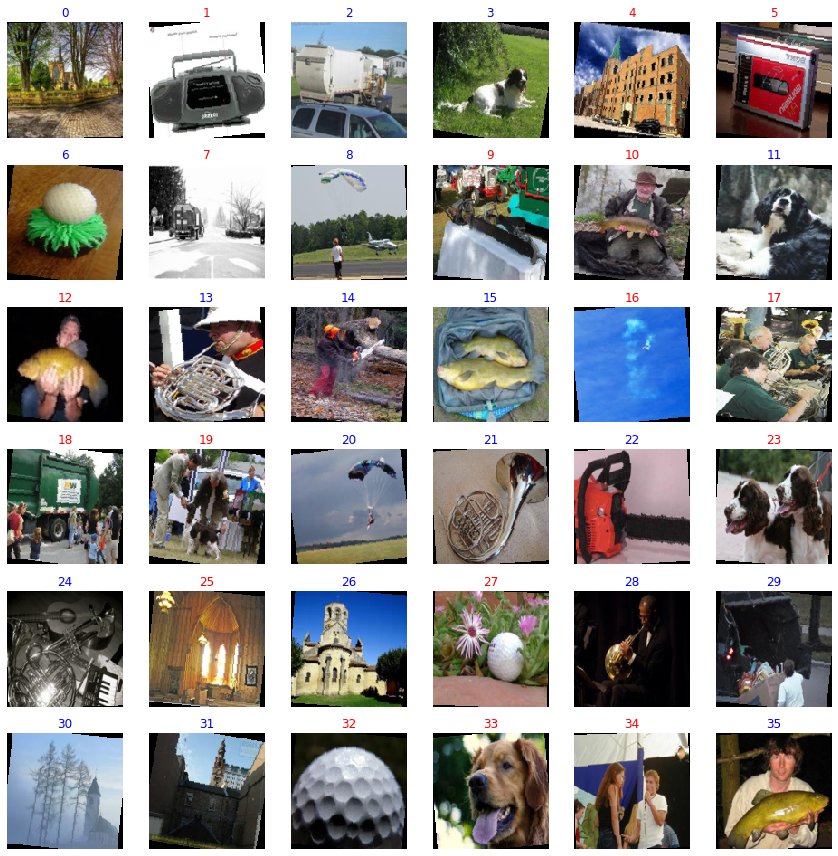

In [94]:
plot_images(images[:36], 
            range(36), 
            title_colors=np.random.choice(['r', 'b'], 36))

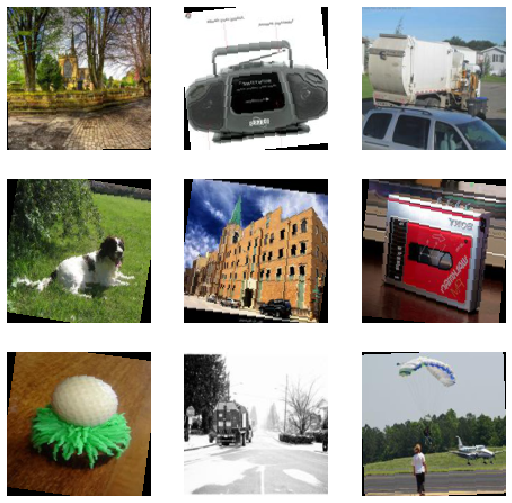

In [41]:
show_images(images, nrows=3)

In [7]:
y_proba = net.predict(*xb)
print(y_proba.shape)
y_proba[:5]

torch.Size([64, 20])


tensor([[ 7.3332e-04,  1.5556e-03, -2.6318e-04, -3.8001e-04, -2.6269e-04,
          1.0917e-05,  1.0635e-04, -3.1522e-04, -1.1735e-04,  6.6421e-04,
          1.6708e-04, -4.0824e-04, -1.6943e-03, -1.3132e-03, -5.8504e-04,
         -8.1054e-04, -2.5766e-04,  1.1644e-04, -2.8701e-04, -3.6061e-04],
        [ 7.3332e-04,  1.5556e-03, -2.6318e-04, -3.8001e-04, -2.6269e-04,
          1.0917e-05,  1.0635e-04, -3.1522e-04, -1.1735e-04,  6.6421e-04,
          1.6708e-04, -4.0824e-04, -1.6943e-03, -1.3132e-03, -5.8504e-04,
         -8.1054e-04, -2.5766e-04,  1.1644e-04, -2.8701e-04, -3.6061e-04],
        [ 7.3332e-04,  1.5556e-03, -2.6318e-04, -3.8001e-04, -2.6269e-04,
          1.0916e-05,  1.0635e-04, -3.1522e-04, -1.1735e-04,  6.6421e-04,
          1.6708e-04, -4.0824e-04, -1.6943e-03, -1.3132e-03, -5.8504e-04,
         -8.1054e-04, -2.5766e-04,  1.1644e-04, -2.8701e-04, -3.6061e-04],
        [ 7.3332e-04,  1.5556e-03, -2.6318e-04, -3.8001e-04, -2.6269e-04,
          1.0916e-05,  1.0635e-04, 

In [8]:
F.cross_entropy(y_proba, yb)

tensor(2.9959)

## Load v10 trained weights

Transferred from SSL v8 (channel shuffle task).

In [6]:
state = torch.load('data/supervised_models/v10/trainer.pkl')
net.load_state_dict(state['model'])

<All keys matched successfully>

In [12]:
y_proba = net.predict(*xb)

In [13]:
post_act = F.softmax(y_proba, -1)
y_max_proba = post_act.max(-1)[0].cpu().numpy()
y_pred = post_act.argmax(-1).cpu().numpy()

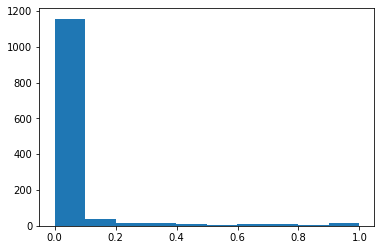

In [14]:
plt.hist(post_act.flatten())
plt.show()

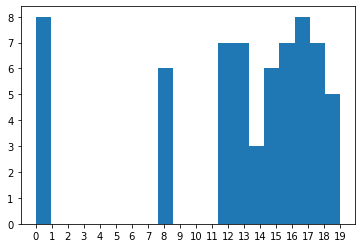

In [15]:
plt.hist(y_pred, bins=20)
plt.xticks(range(20))
plt.show()

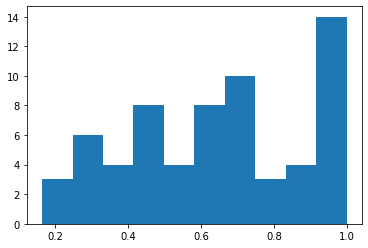

In [16]:
plt.hist(y_max_proba)
plt.show()

In [17]:
F.cross_entropy(y_proba, yb)

tensor(1.1961)

In [31]:
titles = [f'label={lbl.item()}, pred={pred}\nprob={prob:.3f}' 
          for lbl, pred, prob in zip(yb, y_pred, y_max_proba)]

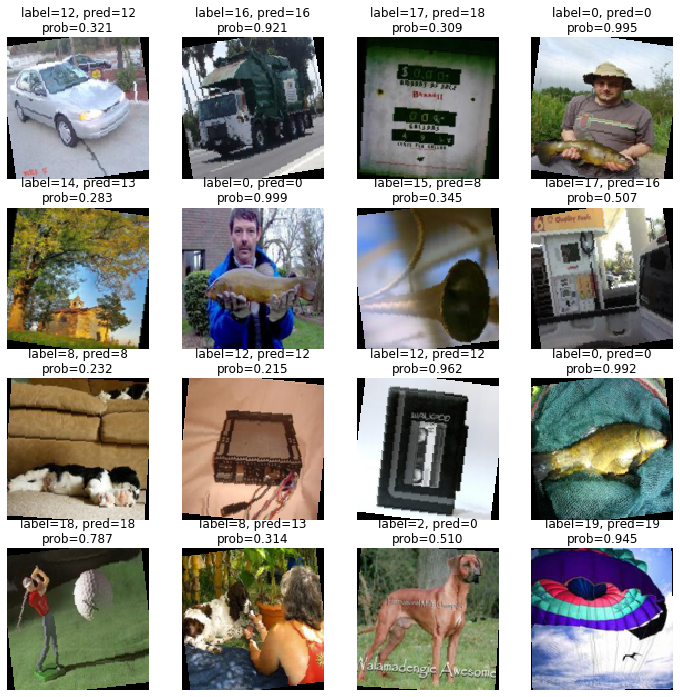

In [20]:
show_images(xb[0][:16], nrows=4, titles=titles[:16])

In [41]:
vcounts(y_pred, False)

{12: 7, 16: 7, 18: 7, 0: 8, 13: 7, 8: 6, 19: 5, 15: 6, 17: 8, 14: 3}

## Validation set

In [67]:
assert dst.class_to_idx == dsv.class_to_idx

In [38]:
sorted(dsv.class_to_idx[subdir] 
       for subdir in os.listdir('data/imagewang-160/val/'))

[1, 2, 3, 4, 5, 6, 7, 9, 10, 11]

In [21]:
*xv, yv = next(iter(dlv))

In [22]:
yv_proba = net.predict(*xv)

In [23]:
post_act_v = F.softmax(yv_proba, -1)
yv_max_proba = post_act_v.max(-1)[0].cpu().numpy()
yv_pred = post_act_v.argmax(-1).cpu().numpy()

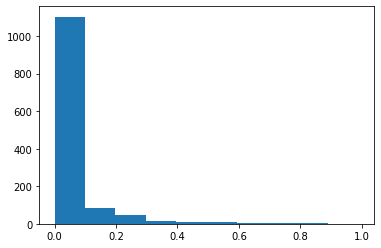

In [24]:
plt.hist(post_act_v.flatten())
plt.show()

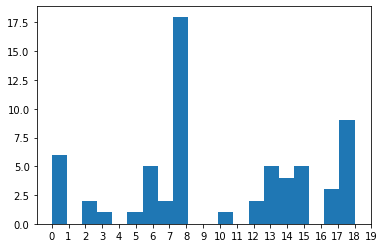

In [25]:
plt.hist(yv_pred, bins=20)
plt.xticks(range(20))
plt.show()

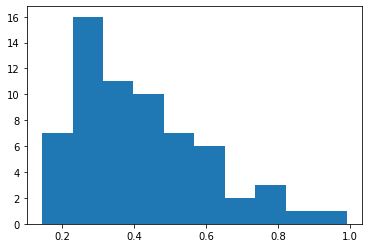

In [26]:
plt.hist(yv_max_proba)
plt.show()

In [27]:
F.cross_entropy(yv_proba, yv)

tensor(4.1468)

In [30]:
titles_v = [f'label={lbl.item()}, pred={pred}\nprob={prob:.3f}' 
            for lbl, pred, prob in zip(yv, yv_pred, yv_max_proba)]

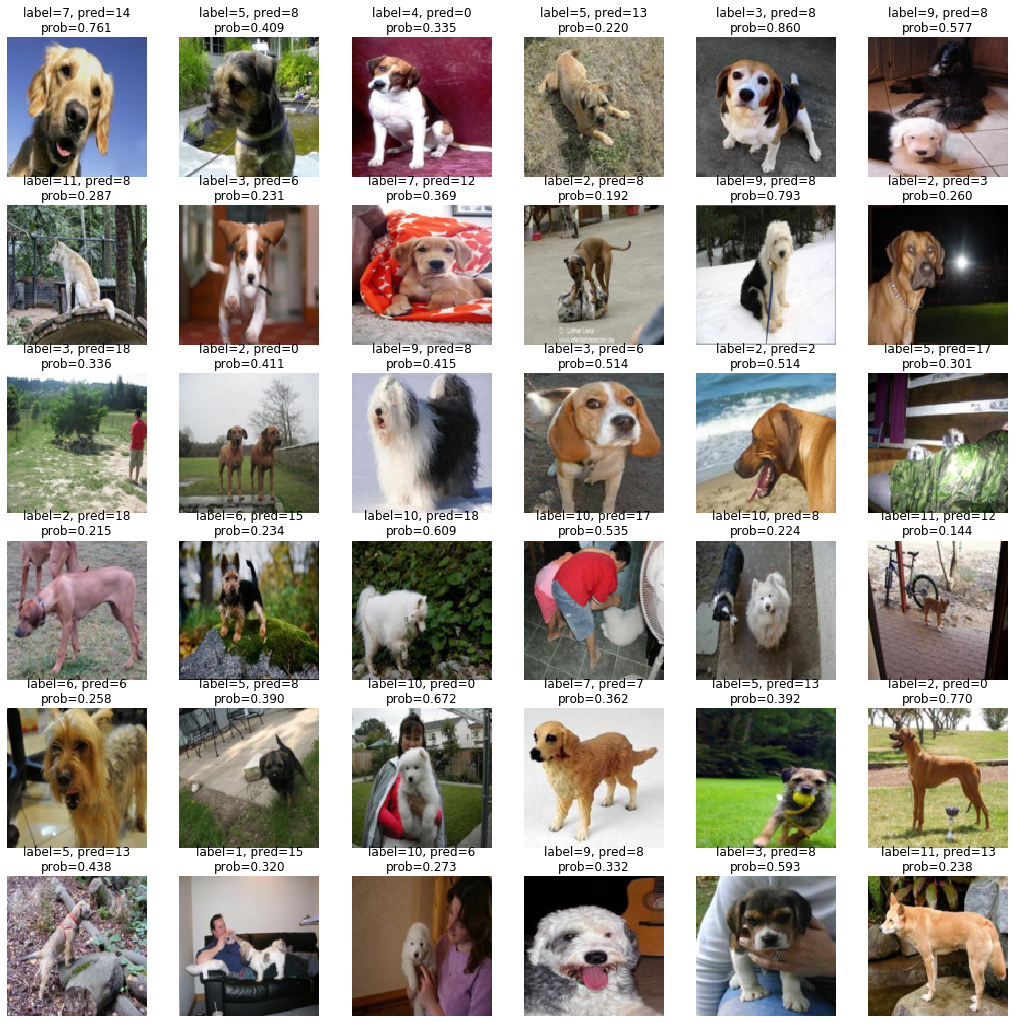

In [31]:
show_images(xv[0][:36], nrows=6, titles=titles_v[:36])

## Top Mistakes

In [7]:
T = Trainer(net, dst, dsv, dlt, dlv, F.cross_entropy, 'multiclass', 
            'data/supervised_models/v10', last_act=nn.Softmax(-1))

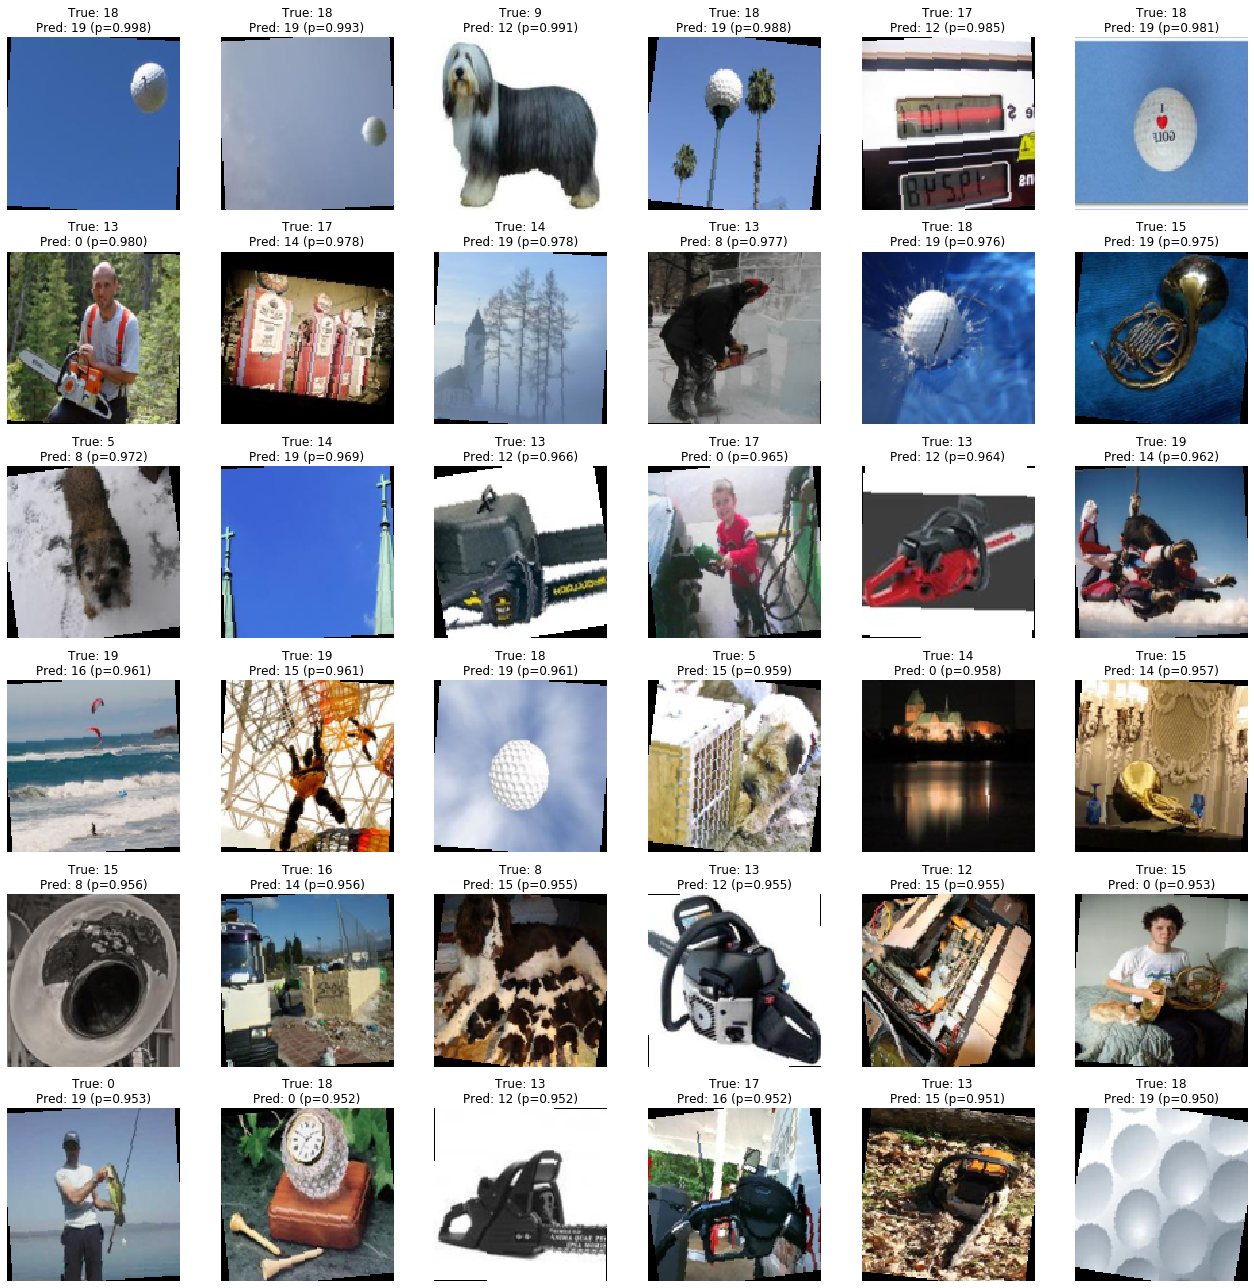

In [59]:
df_train = top_mistakes(T, dl=T.dl_train, n=36)

In [64]:
df_train.ends()

y  y_pred   y_proba                         title  correct
3544   18      19  0.997699  True: 18\nPred: 19 (p=0.998)    False
4770   18      19  0.992819  True: 18\nPred: 19 (p=0.993)    False
6383    9      12  0.991124   True: 9\nPred: 12 (p=0.991)    False
10028   0       0  0.999995    True: 0\nPred: 0 (p=1.000)     True
11827   0       0  0.999995    True: 0\nPred: 0 (p=1.000)     True
11502   0       0  0.999998    True: 0\nPred: 0 (p=1.000)     True

In [65]:
df_train.correct.mean()

0.6316722339627786

In [62]:
# Color is defined row-wise, i.e. darkest color is most common mistake 
# for a given true class.
pd.pivot_table(df_train, index='y', columns='y_pred', values='title',
               aggfunc=len, fill_value=0)\
  .style.background_gradient(axis=1)

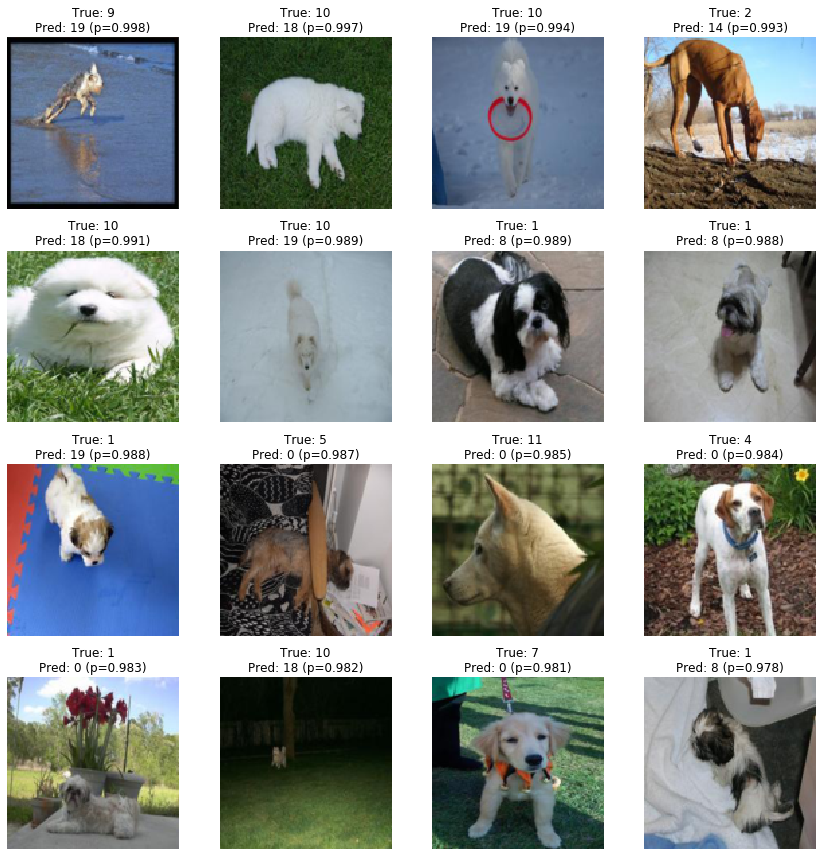

In [57]:
df_val = top_mistakes(T, dl=T.dl_val)

In [58]:
df_val.ends()

y  y_pred   y_proba                         title  correct
2706   9      19  0.998358   True: 9\nPred: 19 (p=0.998)    False
1921  10      18  0.997032  True: 10\nPred: 18 (p=0.997)    False
505   10      19  0.993960  True: 10\nPred: 19 (p=0.994)    False
618    6       6  0.866045    True: 6\nPred: 6 (p=0.866)     True
255    2       2  0.884069    True: 2\nPred: 2 (p=0.884)     True
2679   6       6  0.901534    True: 6\nPred: 6 (p=0.902)     True

In [54]:
df_val.y.vcounts()

y  y_raw_count  y_normed_count
0  10          429        0.109188
1   9          422        0.107406
2   3          418        0.106388
3  11          410        0.104352
4   1          409        0.104098
5   2          408        0.103843
6   6          407        0.103589
7   7          401        0.102062
8   5          401        0.102062
9   4          224        0.057012

In [63]:
# Color is defined row-wise, i.e. darkest color is most common mistake 
# for a given true class.
pd.pivot_table(df_val, index='y', columns='y_pred', values='title',
               aggfunc=len, fill_value=0)\
  .style.background_gradient(axis=1)

In [17]:
df_val.correct.mean()

0.08246373122932044

## V8 weights

Transferred from SSL V4 (patchwork task).

In [75]:
T.load(old_path='data/supervised_models/v8/trainer.pkl')

2020-10-09 05:47:43,085 [INFO]: Loading weights from data/supervised_models/v8/trainer.pkl.


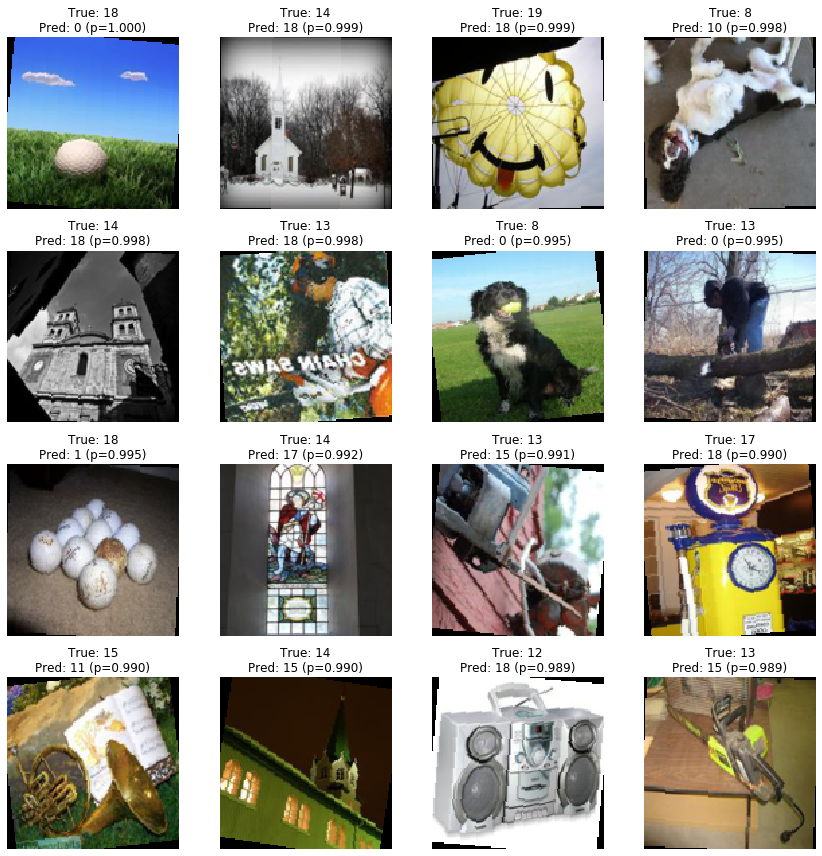

In [76]:
df_train = top_mistakes(T, dl=T.dl_train)

In [78]:
df_train.correct.mean()

0.9468266412161701

In [79]:
# Color is defined row-wise, i.e. darkest color is most common mistake 
# for a given true class.
pd.pivot_table(df_train, index='y', columns='y_pred', values='title',
               aggfunc=len, fill_value=0)\
  .style.background_gradient(axis=1)

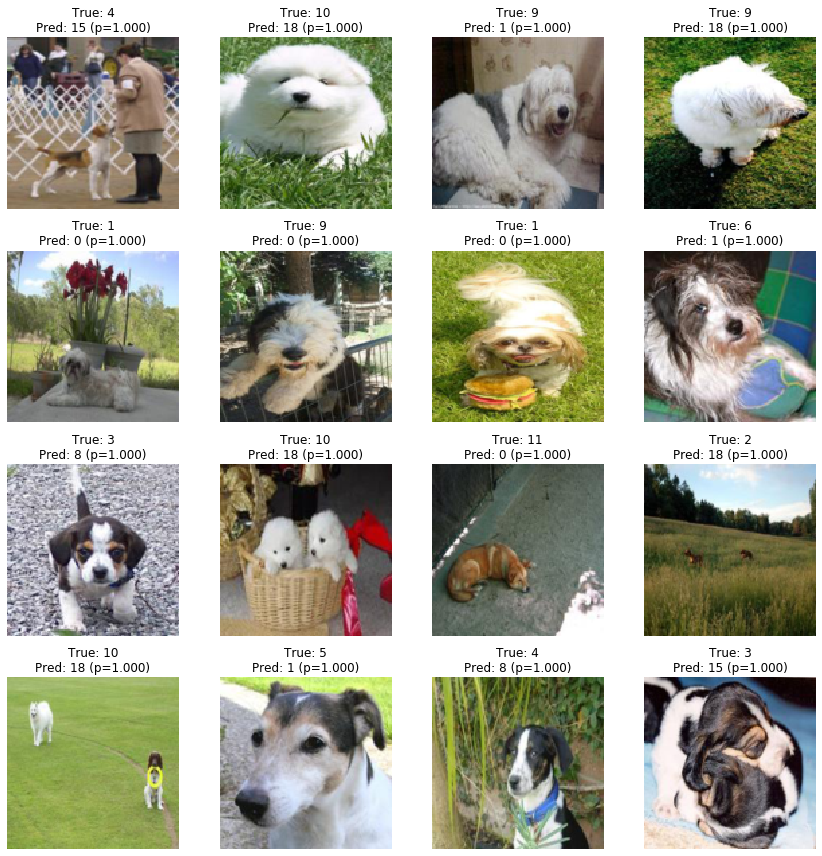

In [80]:
df_val = top_mistakes(T, dl=T.dl_val)

In [84]:
df_val.correct.mean()

0.27411555103079666

In [83]:
# Color is defined row-wise, i.e. darkest color is most common mistake 
# for a given true class.
pd.pivot_table(df_val, index='y', columns='y_pred', values='title',
               aggfunc=len, fill_value=0)\
  .style.background_gradient(axis=1)